In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install bs4

     |████████████████████████████████| 115 kB 848 kB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=97d3295a9e386b1dc79b971576d595c09336b333caab5347a874b82330b6b1c3
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [3]:
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from bs4 import BeautifulSoup
import cv2


imgs_dir = list(sorted(glob('../input/chess-piece-dectection/images/*.png')))
labels_dir = list(sorted(glob("../input/chess-piece-dectection/annotations/*.xml")))

class dataset(Dataset) :
    def __init__(self, imgs, labels) :
        self.imgs = imgs
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.label_dic = {"black-king" : 0, "black-queen" : 1, "black-rook" : 2, "black-knight" : 3, "black-bishop" : 4, "black-pawn" : 5,
                         "white-king" : 6, "white-queen" : 7, "white-rook" : 8, "white-knight" : 9, "white-bishop" : 10, "white-pawn" : 11}
        
    def __len__(self) :
        return len(self.imgs)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.imgs[index])
        x = self.transform(x).to(self.device)
        
        y = dict()
        with open(self.labels[index]) as f :
            data = f.read()
            soup = BeautifulSoup(data, 'xml')
            data = soup.find_all('object')
            
            box = []
            label = []
            for obj in data :
                xmin = int(obj.find('xmin').text)
                ymin = int(obj.find('ymin').text)
                xmax = int(obj.find('xmax').text)
                ymax = int(obj.find('ymax').text)
                
                label_ = self.label_dic[obj.find("name").text]
                if obj.find('name').text == 'with_mask' :
                    label_ = 1
                elif obj.find('name').text == 'mask_weared_incorrect' :
                    label_ = 2
                
                box.append([xmin, ymin, xmax, ymax])
                label.append(label_)
                
            box = torch.FloatTensor(box)
            label = torch.IntTensor(label)
            
            y['image_id'] = torch.FloatTensor([index]).to(device)
            y["boxes"] = box.to(device)
            y["labels"] = torch.as_tensor(label, dtype=torch.int64)
            
        return x, y
    
def collate_fn(batch) : return tuple(zip(*batch))
train_data = dataset(imgs_dir, labels_dir)
train_data = DataLoader(train_data, batch_size = 1, shuffle = True,
                       collate_fn = collate_fn)

In [5]:
#학습된 모델로 사용 : 학습 시간 아끼자.
#load pre-trained model
import torch.nn as nn
import torch.functional as F
import torchvision.models as models

def get_model(output_shape) :
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #사전 학습된 인스턴스 분할 모델 로드
    in_features = model.roi_heads.box_predictor.cls_score.in_features #분류를 위한 입력 특징 차원
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, output_shape) #헤더 교체
    
    return model

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = get_model(12).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0001)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [7]:
#학습
#train
from tqdm.notebook import tqdm

model.train()
num_epoch = 50

for epoch in range(num_epoch) :
    epoch_loss = 0
    
    for imgs, annotations in tqdm(train_data):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        predict = model([imgs[0]], annotations)
        losses = sum(loss for loss in predict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
        
    print(epoch+1, '/', num_epoch, ' : {:.5f}'.format(epoch_loss))
    if epoch_loss < 0.1 :
        print('early stop')
        break

  0%|          | 0/81 [00:00<?, ?it/s]

1 / 50  : 66.58747


  0%|          | 0/81 [00:00<?, ?it/s]

2 / 50  : 48.28332


  0%|          | 0/81 [00:00<?, ?it/s]

3 / 50  : 36.57170


  0%|          | 0/81 [00:00<?, ?it/s]

4 / 50  : 29.21378


  0%|          | 0/81 [00:00<?, ?it/s]

5 / 50  : 24.40414


  0%|          | 0/81 [00:00<?, ?it/s]

6 / 50  : 22.53053


  0%|          | 0/81 [00:00<?, ?it/s]

7 / 50  : 18.68589


  0%|          | 0/81 [00:00<?, ?it/s]

8 / 50  : 16.48357


  0%|          | 0/81 [00:00<?, ?it/s]

9 / 50  : 15.07333


  0%|          | 0/81 [00:00<?, ?it/s]

10 / 50  : 12.86132


  0%|          | 0/81 [00:00<?, ?it/s]

11 / 50  : 12.32351


  0%|          | 0/81 [00:00<?, ?it/s]

12 / 50  : 12.18758


  0%|          | 0/81 [00:00<?, ?it/s]

13 / 50  : 10.50244


  0%|          | 0/81 [00:00<?, ?it/s]

14 / 50  : 9.52698


  0%|          | 0/81 [00:00<?, ?it/s]

15 / 50  : 8.95837


  0%|          | 0/81 [00:00<?, ?it/s]

16 / 50  : 8.83918


  0%|          | 0/81 [00:00<?, ?it/s]

17 / 50  : 8.01542


  0%|          | 0/81 [00:00<?, ?it/s]

18 / 50  : 7.92308


  0%|          | 0/81 [00:00<?, ?it/s]

19 / 50  : 6.88927


  0%|          | 0/81 [00:00<?, ?it/s]

20 / 50  : 6.40351


  0%|          | 0/81 [00:00<?, ?it/s]

21 / 50  : 6.67498


  0%|          | 0/81 [00:00<?, ?it/s]

22 / 50  : 6.17217


  0%|          | 0/81 [00:00<?, ?it/s]

23 / 50  : 7.06178


  0%|          | 0/81 [00:00<?, ?it/s]

24 / 50  : 6.19701


  0%|          | 0/81 [00:00<?, ?it/s]

25 / 50  : 5.71185


  0%|          | 0/81 [00:00<?, ?it/s]

26 / 50  : 5.50415


  0%|          | 0/81 [00:00<?, ?it/s]

27 / 50  : 5.16076


  0%|          | 0/81 [00:00<?, ?it/s]

28 / 50  : 5.81162


  0%|          | 0/81 [00:00<?, ?it/s]

29 / 50  : 4.71593


  0%|          | 0/81 [00:00<?, ?it/s]

30 / 50  : 4.89616


  0%|          | 0/81 [00:00<?, ?it/s]

31 / 50  : 5.40708


  0%|          | 0/81 [00:00<?, ?it/s]

32 / 50  : 5.23494


  0%|          | 0/81 [00:00<?, ?it/s]

33 / 50  : 4.57731


  0%|          | 0/81 [00:00<?, ?it/s]

34 / 50  : 4.74513


  0%|          | 0/81 [00:00<?, ?it/s]

35 / 50  : 4.13098


  0%|          | 0/81 [00:00<?, ?it/s]

36 / 50  : 5.16484


  0%|          | 0/81 [00:00<?, ?it/s]

37 / 50  : 4.71056


  0%|          | 0/81 [00:00<?, ?it/s]

38 / 50  : 4.41271


  0%|          | 0/81 [00:00<?, ?it/s]

39 / 50  : 4.81717


  0%|          | 0/81 [00:00<?, ?it/s]

40 / 50  : 4.36792


  0%|          | 0/81 [00:00<?, ?it/s]

41 / 50  : 4.47736


  0%|          | 0/81 [00:00<?, ?it/s]

42 / 50  : 4.01698


  0%|          | 0/81 [00:00<?, ?it/s]

43 / 50  : 3.39061


  0%|          | 0/81 [00:00<?, ?it/s]

44 / 50  : 3.69998


  0%|          | 0/81 [00:00<?, ?it/s]

45 / 50  : 3.95222


  0%|          | 0/81 [00:00<?, ?it/s]

46 / 50  : 3.99244


  0%|          | 0/81 [00:00<?, ?it/s]

47 / 50  : 3.70432


  0%|          | 0/81 [00:00<?, ?it/s]

48 / 50  : 4.06917


  0%|          | 0/81 [00:00<?, ?it/s]

49 / 50  : 3.50612


  0%|          | 0/81 [00:00<?, ?it/s]

50 / 50  : 3.80008


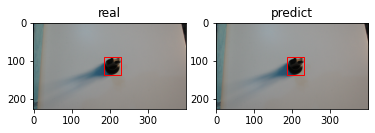

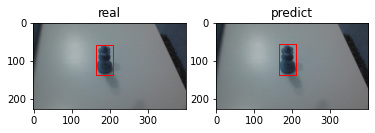

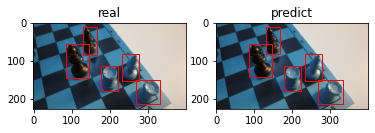

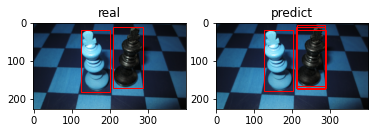

In [10]:
#결과 확인
#get result
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#배치 사이즈 조정해서 재실행 => out of memory 방지
#Resize the batch-size to prevent out of memory

def plot_img(img, predict, annotation) :
    fig, ax = plt.subplots(1, 2)
    img = img.cpu().data
    
    ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
    ax[1].imshow(img.permute(1, 2, 0))
    ax[0].set_title("real")
    ax[1].set_title("predict")
    
    for box in annotation["boxes"] :
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
        
    for box in predict["boxes"] :
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
    plt.show()

model.eval()

with torch.no_grad() :
    for i, (imgs, annotations) in enumerate(train_data):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        predict = model([imgs[0]])
        
        plot_img(imgs[0], predict[0], annotations[0])
        
        if i == 3 : break